In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

from sklearn.impute import KNNImputer
from scipy import stats
from scipy.stats import norm, skew
import plotly.express as px


plt.style.use("seaborn-white")
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
gk = pd.read_pickle("/content/drive/My Drive/Capstone/Data/Clean/engineering_data/gk_transfers_info.pkl")
defenders = pd.read_pickle("/content/drive/My Drive/Capstone/Data/Clean/engineering_data/defenders_transfers_info.pkl")
midfielders = pd.read_pickle("/content/drive/My Drive/Capstone/Data/Clean/engineering_data/midfielders_transfers_info.pkl")
attackers = pd.read_pickle("/content/drive/My Drive/Capstone/Data/Clean/engineering_data/attackers_transfers_info.pkl")
players = pd.read_pickle("/content/drive/My Drive/Capstone/Data/Clean/engineering_data/Players_Clean.pkl")

In [0]:
gk['tourn_year'] = np.where(gk['year'] %2 == 0, 1, 0)
defenders['tourn_year'] = np.where(defenders['year'] %2 == 0, 1, 0)
midfielders['tourn_year'] = np.where(midfielders['year'] %2 == 0, 1, 0)
attackers['tourn_year'] = np.where(attackers['year'] % 2 == 0, 1, 0)

In [0]:
defenders = pd.merge(defenders, players[["tm_id","continent"]], on = "tm_id")
midfielders = pd.merge(midfielders, players[["tm_id","continent"]], on = "tm_id")
attackers = pd.merge(attackers, players[["tm_id","continent"]], on = "tm_id")

In [0]:
gk["fee_log"] = np.log1p(gk.fee)
defenders["fee_log"] = np.log1p(defenders.fee)
midfielders["fee_log"] = np.log1p(midfielders.fee)
attackers["fee_log"] = np.log1p(attackers.fee)

In [0]:
def plot_dist(df,var):
  plt.style.use("seaborn-white")
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10, 15))
  ax1 = sns.distplot(df[var], fit = norm, ax = ax1)
  ax2 = stats.probplot(df[var], plot = ax2)
  ax1.set_xlabel("Transfer Fee", fontsize = 13)
  ax1.set_title("Transfer Fee Distribution")
  plt.show()

def heat_map(df,title, diagonal = "both", w = 30,h = 20):
  df = df.select_dtypes(include=['float64'])
  corr = df.corr()
  plt.figure(figsize = (w, h))
  if(diagonal == "lower"):
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    ax = sns.heatmap(corr, annot = True, linewidths=.5, mask = mask)
  elif(diagonal == "upper"):
    mask = np.tril(np.ones_like(corr, dtype=np.bool))
    ax = sns.heatmap(corr, annot = True, linewidths=.5, mask = mask)
  else:
    ax = sns.heatmap(corr, annot = True, linewidths=.5)
  ax.tick_params(right=True, top=True, labelright=True, labeltop=True)
  plt.title(title, fontsize = 20)
  plt.show()
  return plt

def scatter(df, xvar, yvar, labels, title, facet_var = "main_field_position",
            facet = False, facet_row = False, facet_row_var = "continent"):
  transfers_plot = ( df >> mask(X[xvar].notnull(), X[yvar].notnull()))
  if(facet):
    fig = px.scatter(transfers_plot, xvar, yvar,hover_data = ["name","age","nationality","from",
                                                              "to","year", "fee","mv"],
                    labels = {xvar:"", yvar:""},
                    title = title, color = facet_var ,trendline = "ols",
                    facet_col = facet_var, facet_col_wrap = 2)
  elif(facet_row):
    fig = px.scatter(transfers_plot, xvar, yvar,hover_data = ["name","age","nationality","from",
                                                              "to","year", "fee","mv"],
                labels = {xvar:"", yvar:""},
                title = title, color = facet_var,trendline = "ols",
                facet_col = facet_var, facet_col_wrap = 2, facet_row = facet_row_var)
  else: 
    fig = px.scatter(transfers_plot, xvar, yvar,hover_data = ["name","age","nationality","from",
                                                              "to","year", "fee","mv"], 
                  labels = labels, trendline = "ols",
                  title = title, color = "main_field_position" )
    
  fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))
  fig.for_each_trace(lambda t: t.update(name=t.name.split("=")[1]))
  corr, _ = pearsonr(transfers_plot[xvar],transfers_plot[yvar])
  print("Correlation between the variables",corr)
  fig.show()
  return fig

def cat_num_boxplot(df, cat_feature, num_feature, x_label, y_label, title, remove_outliers = True):
  plot_df = df[(df[cat_feature].notnull()) & (df[num_feature].notnull())]
  ft = plot_df[num_feature]
  if(remove_outliers):
    plot_df = plot_df[plot_df[num_feature].between(ft.quantile(.15), ft.quantile(.85))]
  fig = px.box(plot_df, x=cat_feature, y=num_feature,
               title=title,
               labels = {cat_feature: x_label, num_feature: y_label},
               hover_data = ["age","field_position"],
               )
  fig.update_layout(xaxis_type='category')
  fig.show()

# log(1+x) transformation

In [0]:
overall = pd.concat([gk[['fee']], defenders[['fee']], midfielders[['fee']], attackers[['fee']]])
overall['fee_log'] = np.log1p(overall['fee'])

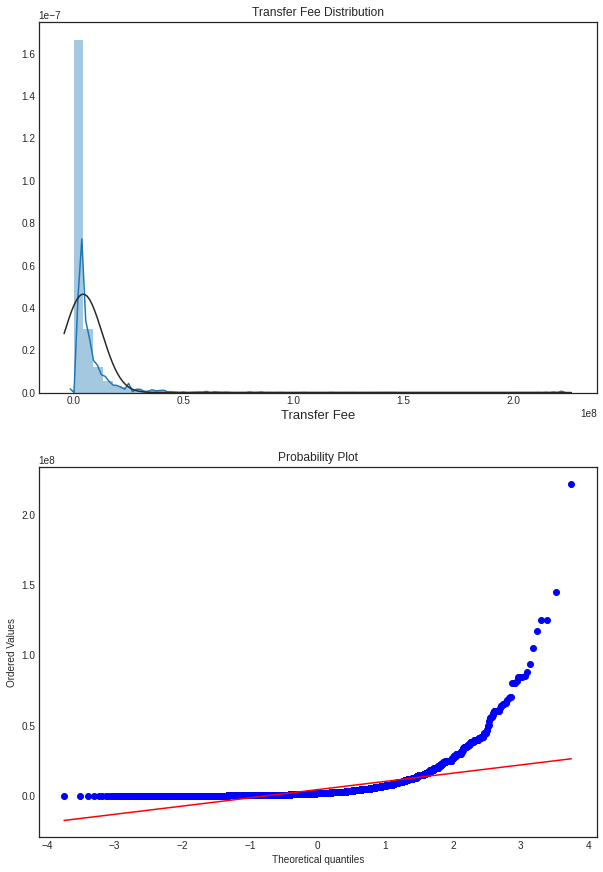

In [0]:
plot_dist(overall,'fee')

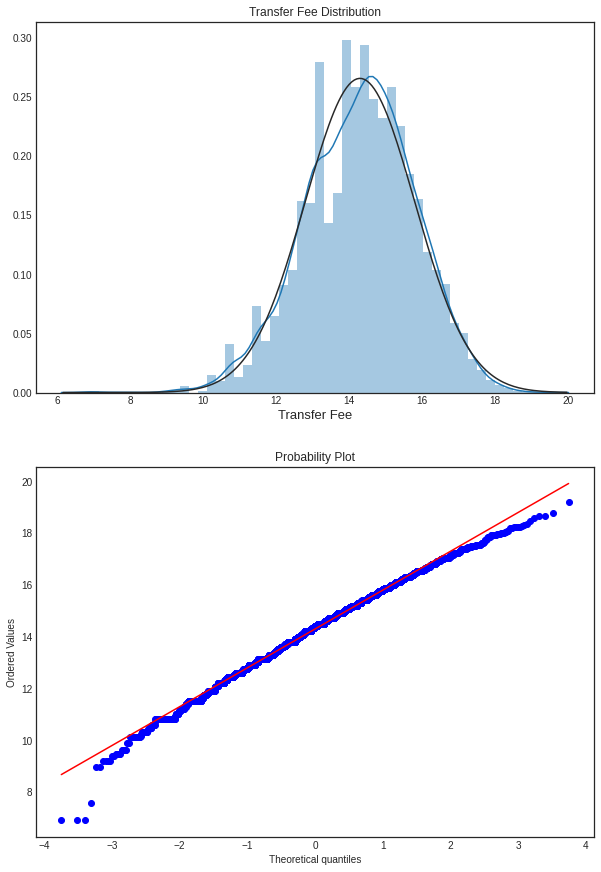

In [0]:
plot_dist(overall,'fee_log')

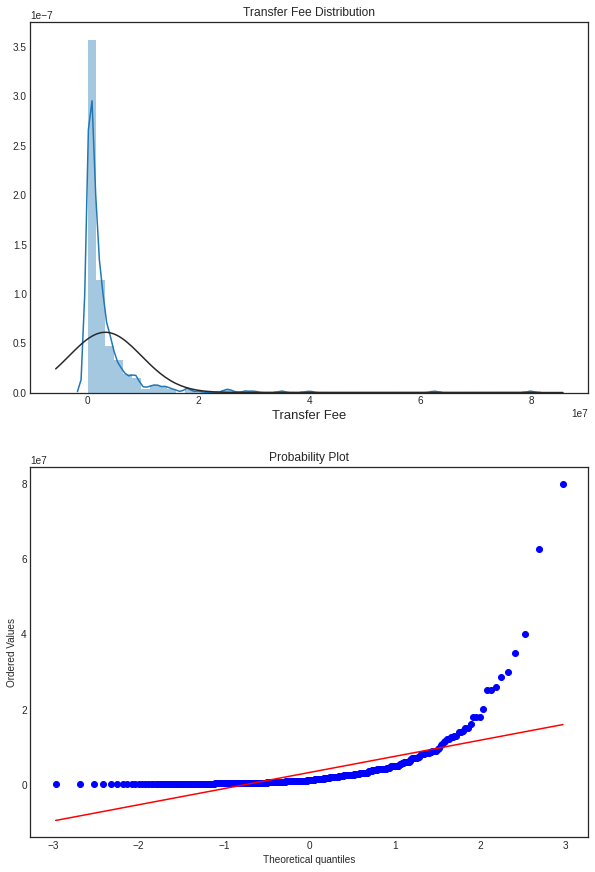

In [0]:
plot_dist(gk, 'fee')

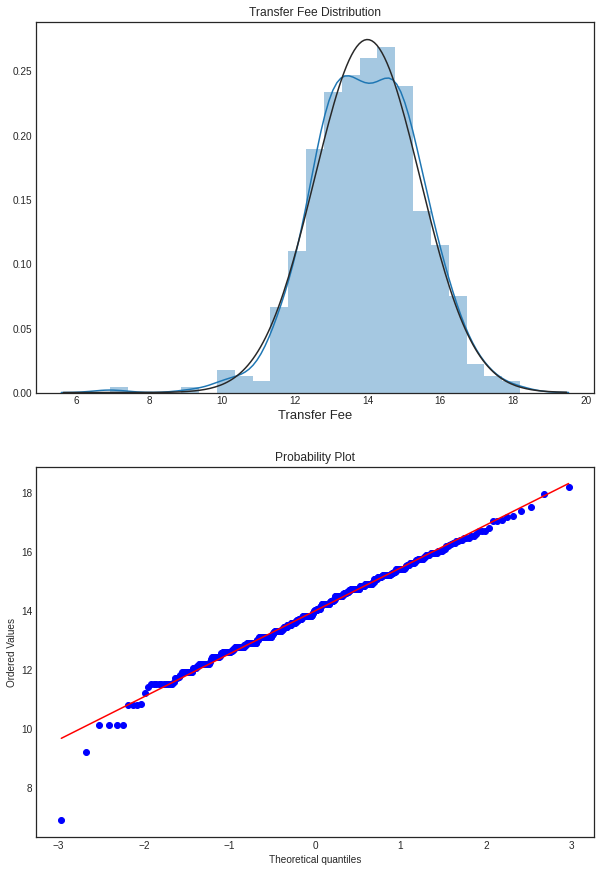

In [0]:
plot_dist(gk, 'fee_log')

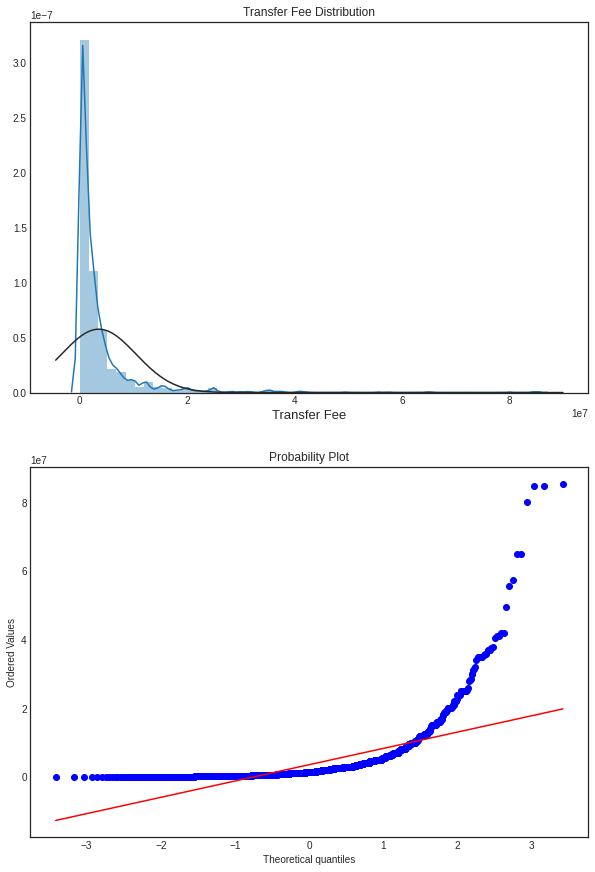

In [0]:
plot_dist(defenders, 'fee')

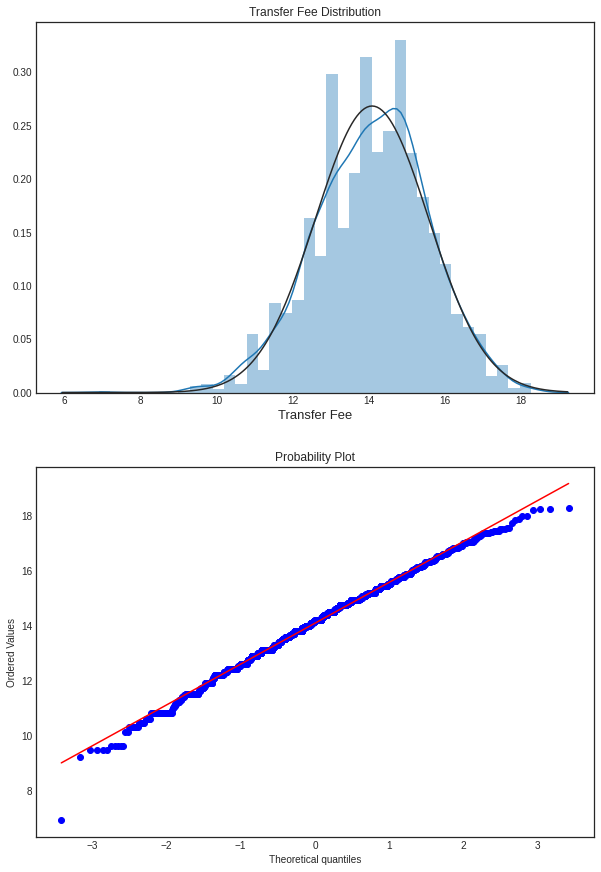

In [0]:
plot_dist(defenders, 'fee_log')

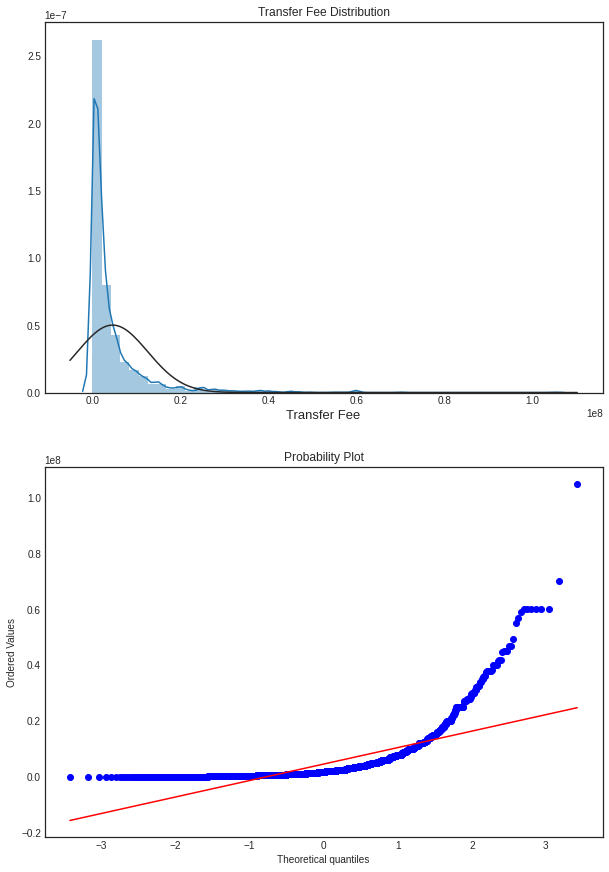

In [0]:
plot_dist(midfielders, 'fee')

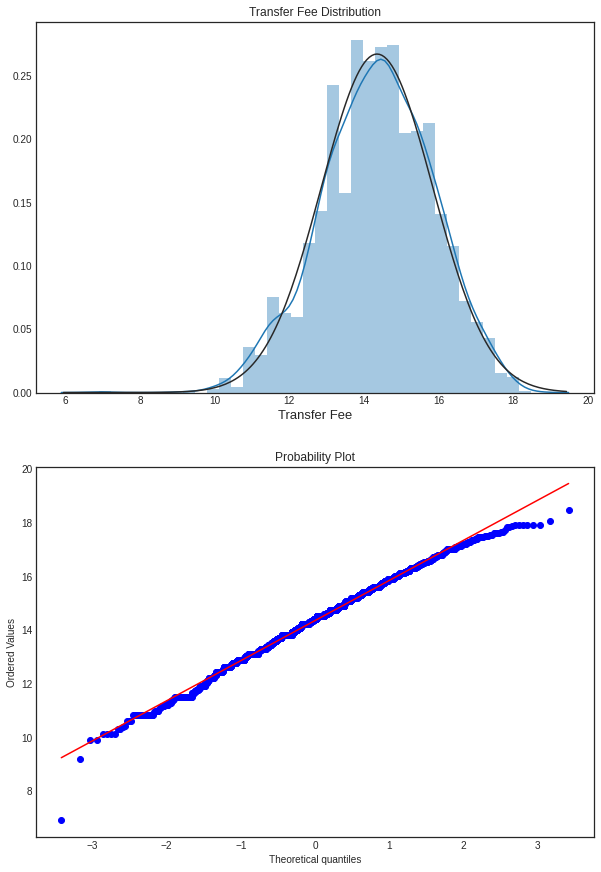

In [0]:
plot_dist(midfielders, 'fee_log')

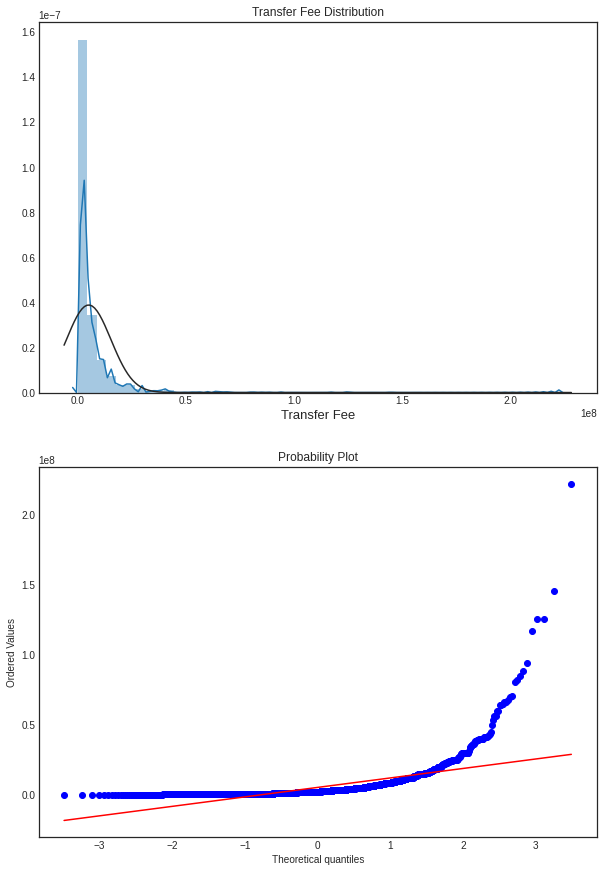

In [0]:
plot_dist(attackers, 'fee')

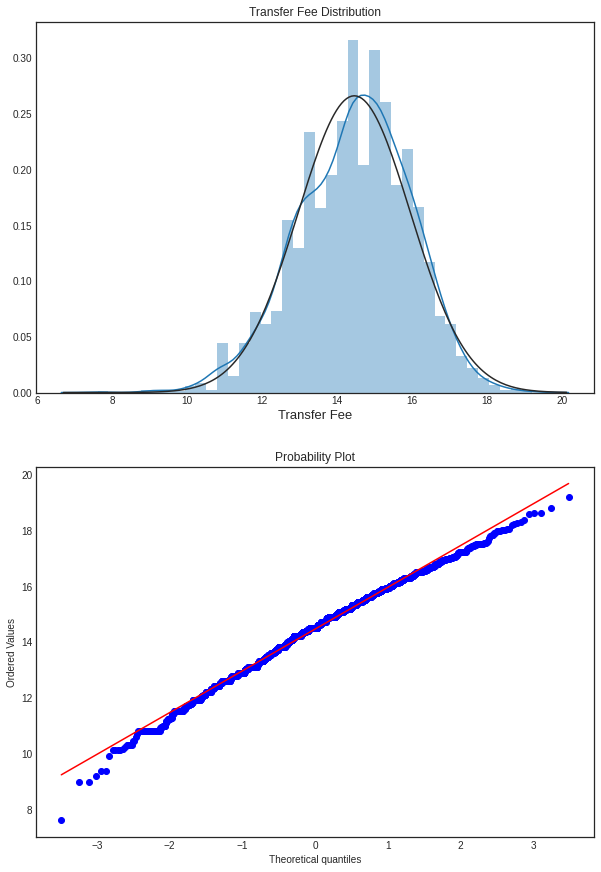

In [0]:
plot_dist(attackers, 'fee_log')

# Missing Values

In [0]:
def drop_and_split(df, drop_columns):
  df.dropna(subset = drop_columns, inplace = True)
  df.reset_index(drop = True, inplace = True) 
  df_imput = df.select_dtypes(include = ["float64"])
  df_rest = df.select_dtypes(exclude = ["float64"])
  return df_rest,df_imput

def apply_knn(df_imputed, df_rest):
  knn = KNNImputer()
  cols = df_imputed.columns
  df_imputed = knn.fit_transform(df_imputed)
  df_imputed = pd.DataFrame(df_imputed)
  df_imputed.columns = cols
  df_final = pd.concat([df_rest, df_imputed], axis = 1)
  return df_final

In [0]:
gk_rest,gk_imputed = drop_and_split(gk, ["dob", "age", "sf"])
gk_final = apply_knn(gk_imputed,gk_rest)

defenders_rest,defenders_imputed = drop_and_split(defenders, ["age", "sf"])
defenders_final = apply_knn(defenders_imputed,defenders_rest)

midfielders_rest,midfielders_imputed = drop_and_split(midfielders, ["age", "sf"])
midfielders_final = apply_knn(midfielders_imputed,midfielders_rest)


attackers_rest,attackers_imputed = drop_and_split(attackers, ["age", "sf"])
attackers_final = apply_knn(attackers_imputed,attackers_rest)

In [0]:
gk_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 462 non-null    datetime64[ns]
 1   tm_id                462 non-null    int64         
 2   from                 462 non-null    object        
 3   to                   462 non-null    object        
 4   transfer_season      462 non-null    object        
 5   loan                 462 non-null    bool          
 6   type                 462 non-null    category      
 7   main_field_position  462 non-null    category      
 8   continent            462 non-null    category      
 9   field_position       462 non-null    category      
 10  sf                   462 non-null    object        
 11  dob                  462 non-null    datetime64[ns]
 12  stats_season         462 non-null    category      
 13  tourn_year           462 non-null  

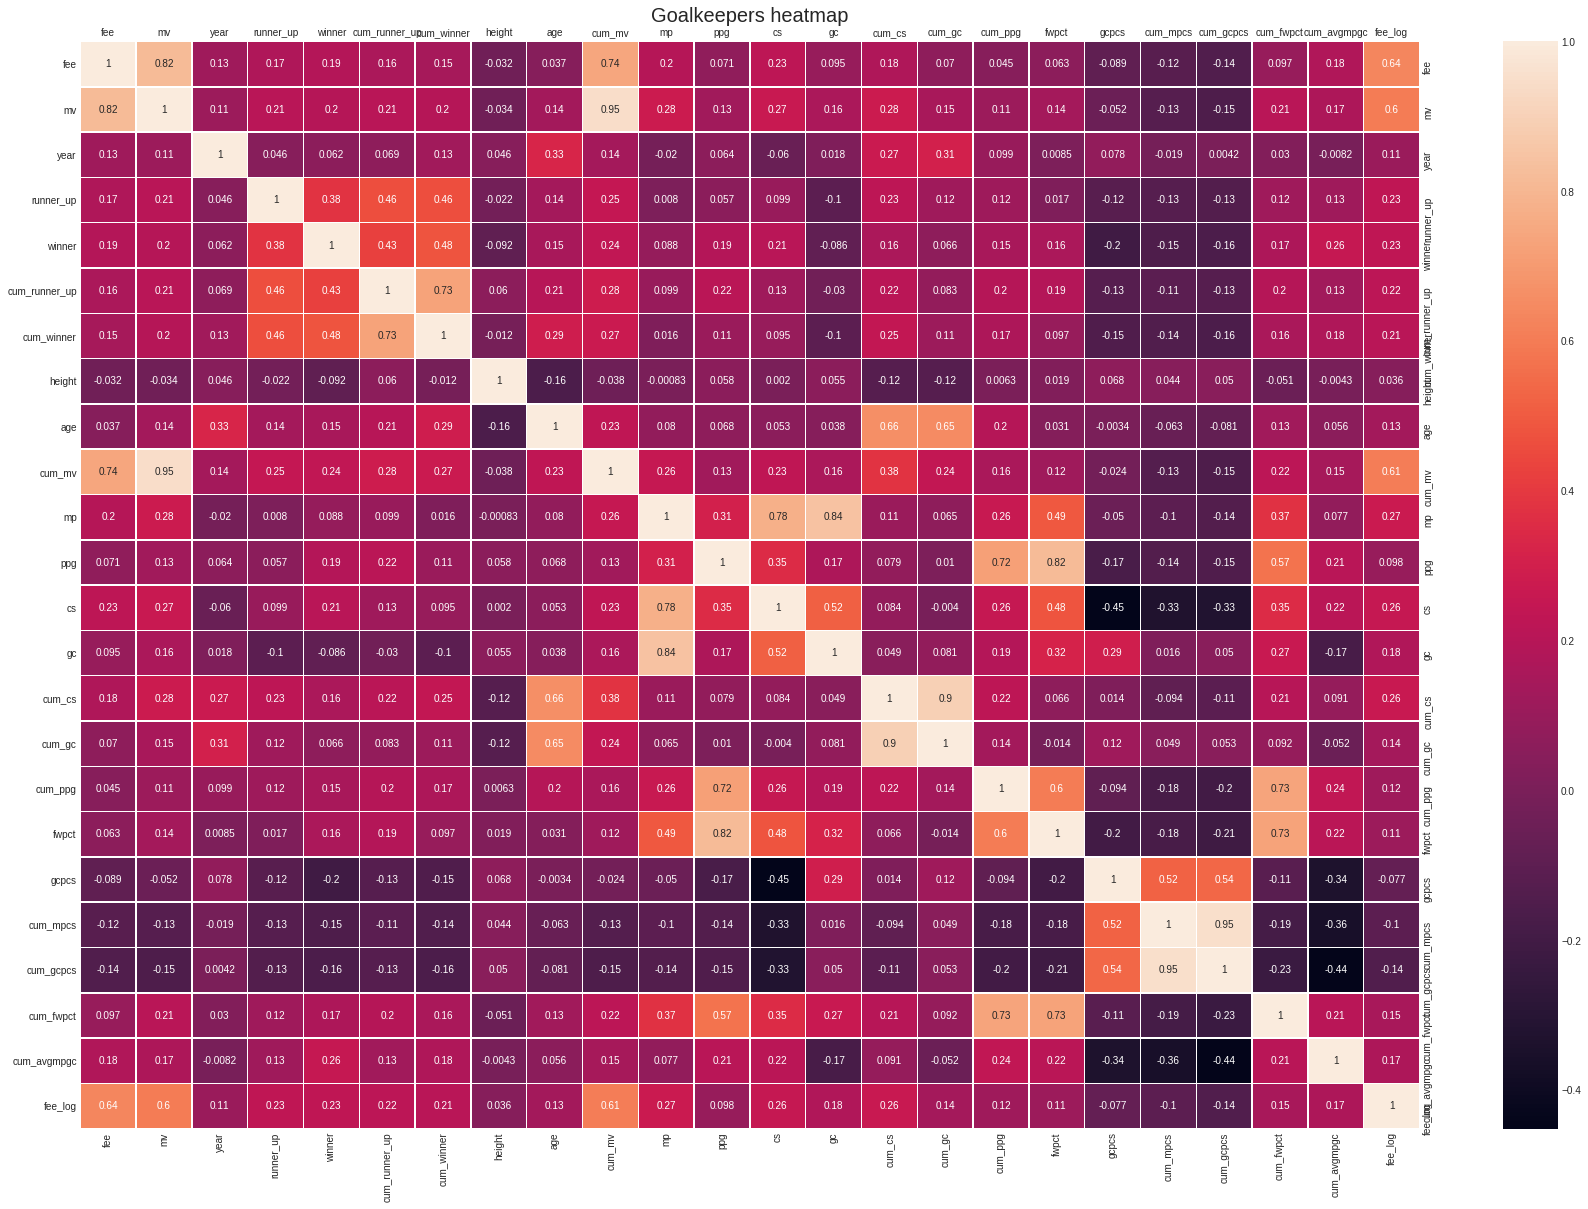

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [0]:
heat_map(gk_final,"Goalkeepers heatmap")

In [0]:
cat_num_boxplot(defenders_final,"field_position","fee","Field Position","Transfer Fee",
                "Transfer fee by field position",remove_outliers = False)

In [0]:
cat_num_boxplot(midfielders_final,"field_position","fee","Field Position","Transfer Fee",
                "Transfer fee by field position",remove_outliers = False)

In [0]:
cat_num_boxplot(attackers_final,"field_position","fee","Field Position","Transfer Fee",
                "Transfer fee by field position",remove_outliers = False)

In [0]:
cat_num_boxplot(attackers_final,"continent","fee","Field Position","Transfer Fee",
                "Transfer fee by continent",remove_outliers = False)

In [0]:
cat_num_boxplot(midfielders_final,"tourn_year","fee","Field Position","Transfer Fee",
                "Transfer fee by tourn_year",remove_outliers = False)

In [0]:
# gk_final.to_pickle("/content/drive/My Drive/Capstone/Data/Clean/gk_final.pkl")
# defenders_final.to_pickle("/content/drive/My Drive/Capstone/Data/Clean/defenders_final.pkl")
# midfielders_final.to_pickle("/content/drive/My Drive/Capstone/Data/Clean/midfielders_final.pkl")
# attackers_final.to_pickle("/content/drive/My Drive/Capstone/Data/Clean/attackers_final.pkl")